In [ ]:
%pip install -q --no-cache-dir \
    torch==2.3.1 \
    torchvision==0.18.1 \
    diffusers==0.27.2 \
    transformers==4.41.2 \
    accelerate==0.30.1 \
    huggingface-hub==0.23.0 \
    numpy==1.26.4 \
    Pillow==10.3.0 \
    ipython==8.25.0 \
    lpips==0.1.4

# Core ML/DL Packages
# Standard Python Libraries
import os
import random

# Image and Data Manipulation
import numpy as np
import torch
from collection.abc import Sequence
from diffusers import EulerAncestralDiscreteScheduler, StableDiffusionInstructPix2PixPipeline

# Jupyter/IPython specific
from PIL import Image, ImageDraw, ImageFont

In [ ]:
def _set_seed(seed: int) -> None:
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.Generator(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def resize(image: Image, min_dimension: int = 256, divisible_by: int = 8) -> Image:
    """Resize image to be small enough for SD, and also ensure pixels are divisible by 8."""
    original_w, original_h = image.size

    if original_w < original_h:
        new_w = min_dimension
        new_h = int(new_w * (original_h / original_w))
    else:
        new_h = min_dimension
        new_w = int(new_h * (original_w / original_h))

    # Round to the nearest multiple of `divisible_by`
    new_w = round(new_w / divisible_by) * divisible_by
    new_h = round(new_h / divisible_by) * divisible_by

    resized_image = image.resize((new_w, new_h), Image.Resampling.LANCZOS)
    print(f"Resized from {original_w}x{original_h} to {new_w}x{new_h}")
    return resized_image


def create_labeled_grid(images: Image, labels: Sequence[str], rows: int, cols: int, title: str = "") -> Image:
    """Creates a grid of images with labels underneath them."""
    w, h = images[0].size
    label_height = 30
    title_height = 40 if title else 0

    grid_w = cols * w
    grid_h = rows * (h + label_height) + title_height

    grid = Image.new("RGB", size=(grid_w, grid_h), color="white")
    draw = ImageDraw.Draw(grid)

    font = ImageFont.load_default()

    bbox = draw.textbbox((0, 0), title, font=font)
    text_w = bbox[2] - bbox[0]
    draw.text(((grid_w - text_w) / 2, 10), title, fill="black", font=font)

    # Draw images and labels
    for i, (img, label) in enumerate(zip(images, labels, strict=False)):
        row, col = divmod(i, cols)

        x = col * w
        y = title_height + row * (h + label_height)

        grid.paste(img, box=(x, y))

        bbox = draw.textbbox((0, 0), label, font=font)
        text_w = bbox[2] - bbox[0]
        draw.text((x + (w - text_w) / 2, y + h + 5), label, fill="black", font=font)

    return grid

In [ ]:
SEED = 1
_set_seed(SEED)

print("Loading InstructPix2Pix model...")
model_id = "timbrooks/instruct-pix2pix"
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    safety_checker=None,
)
pipe.to("cuda")
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
print("Model loaded successfully!")

prompts = [
    "simulate realistic drizzly weather",
    "simulate realistic medium rainy weather, wet and reflective surfaces",
    "simulate realistic heavy rainy weather, many raindrops on camera, wet and reflective surfaces",
]
prompt_names = ["light", "medium", "heavy"]

strength_values = [0.5, 0.8, 1.0]
text_guidance_values = [7.5, 8.0, 8.5]
image_guidance_values = [1.5, 2.0, 2.5]

default_strength = 1
default_text_guidance = 8.0
default_image_guidance = 2.0

print(f"Strength values: {strength_values}")
print(f"Text guidance values: {text_guidance_values}")
print(f"Image guidance values: {image_guidance_values}")

/home/khq.kitware.com/shitij.govil/miniconda3/envs/nrtk-env/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading InstructPix2Pix model...


Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00,  7.47it/s]


Model loaded successfully!
Strength values: [0.5, 0.8, 1.0]
Text guidance values: [7.5, 8.0, 8.5]
Image guidance values: [1.5, 2.0, 2.5]


Found 1 images to process: ['aerial_street.png']
Resized from 1920x1080 to 456x256


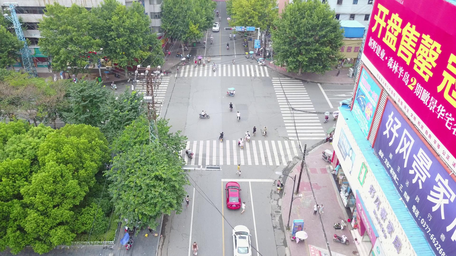

In [4]:
# Get list of images to process
image_files = [f for f in os.listdir("../images") if f.lower() == "aerial_street.png"]
print(f"Found {len(image_files)} images to process: {image_files}")

# Load and resize all images
processed_images = {}
for filename in image_files:
    input_path = os.path.join("../images", filename)
    original_image = Image.open(input_path).convert("RGB")

    # Resize to optimal size for InstructPix2Pix
    resized_image = resize(original_image)

    base_filename = os.path.splitext(filename)[0]
    processed_images[base_filename] = resized_image

    # Display the resized image
    display(resized_image)

## Strength Experiment
It acts at the start of sampling, and is the amount of noise added to the image. The lower it is, the more geometry and colors are kept frozen

Running experiments on: aerial_street
Using medium rain prompt: simulate realistic medium rainy weather, wet and reflective surfaces

1. Running strength experiment...


100%|██████████| 50/50 [00:01<00:00, 27.13it/s]


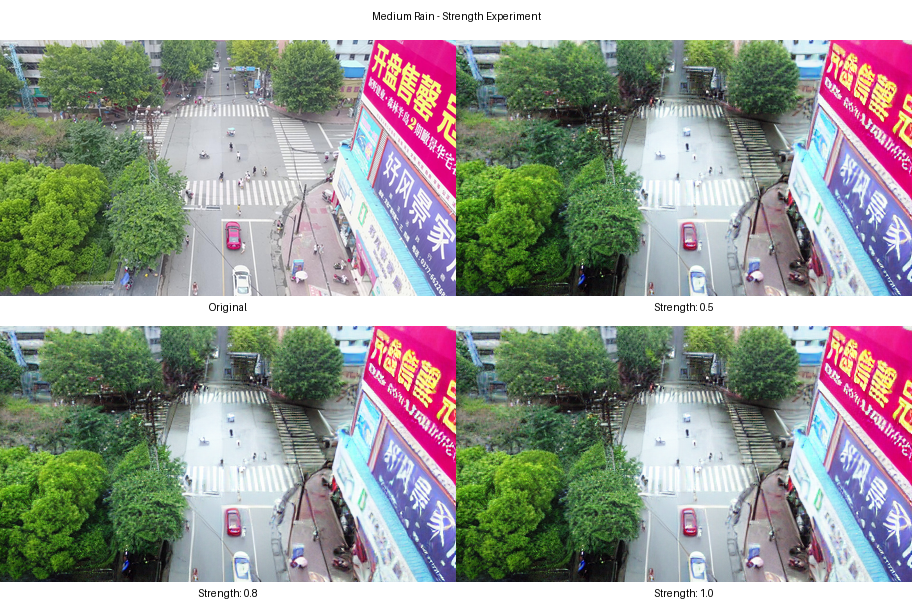

In [5]:
image_to_process = list(processed_images.keys())[0]

input_image = processed_images[image_to_process]
print(f"Running experiments on: {image_to_process}")

# Choose rain intensity (0=light, 1=medium, 2=heavy)
rain_intensity = 1  # medium rain
prompt = prompts[rain_intensity]
prompt_name = prompt_names[rain_intensity]

print(f"Using {prompt_name} rain prompt: {prompt}")

# Experiment 1: Strength variations
print("\n1. Running strength experiment...")
strength_images = [input_image]
strength_labels = ["Original"]

for strength in strength_values:
    generator = torch.Generator(device="cuda").manual_seed(SEED)
    images = pipe(
        prompt,
        image=input_image,
        num_inference_steps=50,
        guidance_scale=default_text_guidance,
        image_guidance_scale=default_image_guidance,
        strength=strength,
        generator=generator,
    ).images
    strength_images.append(images[0])
    strength_labels.append(f"Strength: {strength}")

strength_grid = create_labeled_grid(
    strength_images,
    strength_labels,
    2,
    2,
    f"{prompt_name.title()} Rain - Strength Experiment",
)
display(strength_grid)

## Text Guidance


2. Running text guidance experiment...


  8%|▊         | 4/50 [00:00<00:01, 30.42it/s]

100%|██████████| 50/50 [00:01<00:00, 26.92it/s]


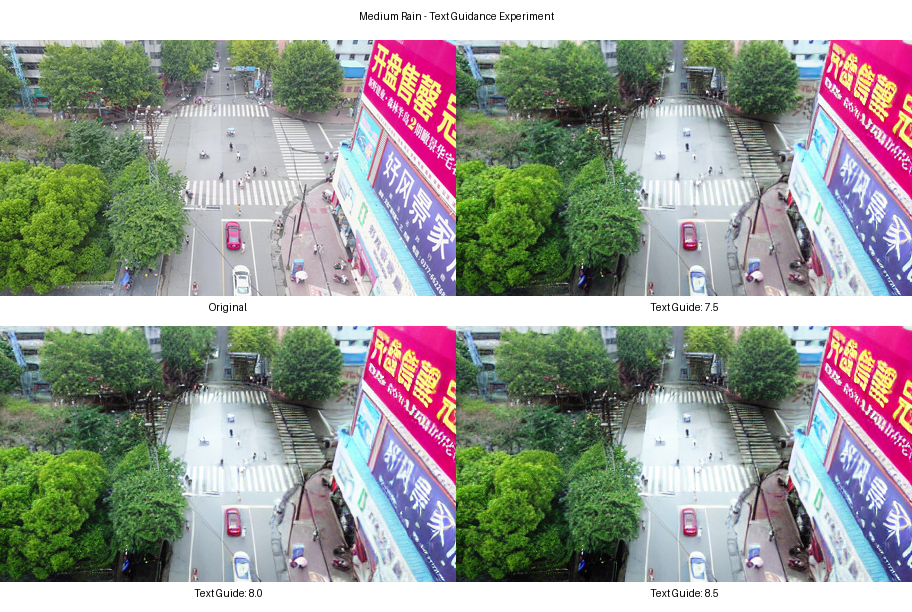

In [6]:
# Experiment 2: Text guidance variations

print("\n2. Running text guidance experiment...")
text_guidance_images = [input_image]
text_guidance_labels = ["Original"]

for text_guidance in text_guidance_values:
    generator = torch.Generator(device="cuda").manual_seed(SEED)
    images = pipe(
        prompt,
        image=input_image,
        num_inference_steps=50,
        guidance_scale=text_guidance,
        image_guidance_scale=default_image_guidance,
        strength=default_strength,
        generator=generator,
    ).images
    text_guidance_images.append(images[0])
    text_guidance_labels.append(f"Text Guide: {text_guidance}")

text_guidance_grid = create_labeled_grid(
    text_guidance_images,
    text_guidance_labels,
    2,
    2,
    f"{prompt_name.title()} Rain - Text Guidance Experiment",
)

display(text_guidance_grid)

## Image Guidance


3. Running image guidance experiment...


  8%|▊         | 4/50 [00:00<00:01, 31.22it/s]

100%|██████████| 50/50 [00:01<00:00, 26.79it/s]


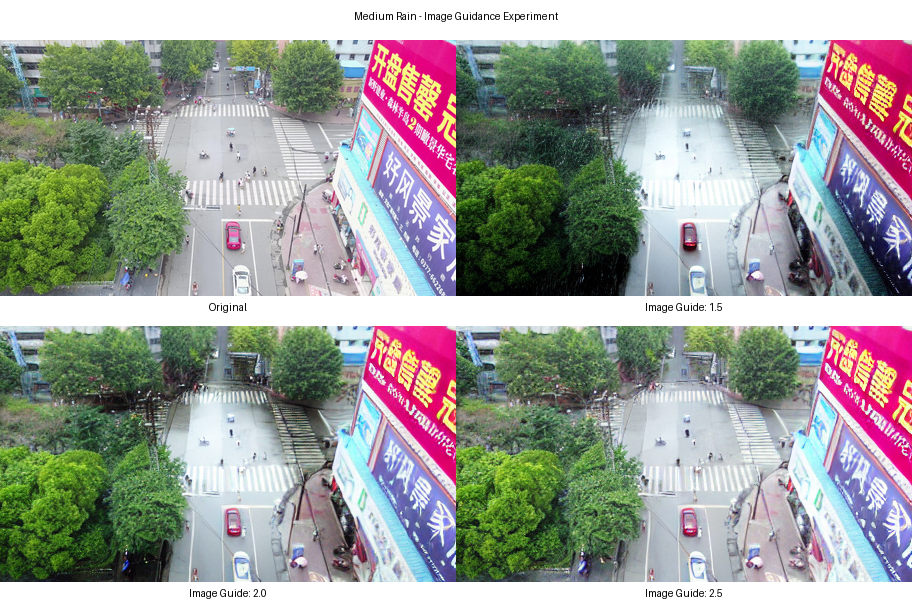

In [7]:
# Experiment 3: Image guidance variations

print("\n3. Running image guidance experiment...")
image_guidance_images = [input_image]
image_guidance_labels = ["Original"]

for image_guidance in image_guidance_values:
    generator = torch.Generator(device="cuda").manual_seed(SEED)
    images = pipe(
        prompt,
        image=input_image,
        num_inference_steps=50,
        guidance_scale=default_text_guidance,
        image_guidance_scale=image_guidance,
        strength=default_strength,
        generator=generator,
    ).images
    image_guidance_images.append(images[0])
    image_guidance_labels.append(f"Image Guide: {image_guidance}")

image_guidance_grid = create_labeled_grid(
    image_guidance_images,
    image_guidance_labels,
    2,
    2,
    f"{prompt_name.title()} Rain - Image Guidance Experiment",
)

display(image_guidance_grid)

## Various Guidance Combinations


4. Running complex combinations experiment...


  8%|▊         | 4/50 [00:00<00:01, 29.90it/s]

100%|██████████| 50/50 [00:01<00:00, 26.68it/s]


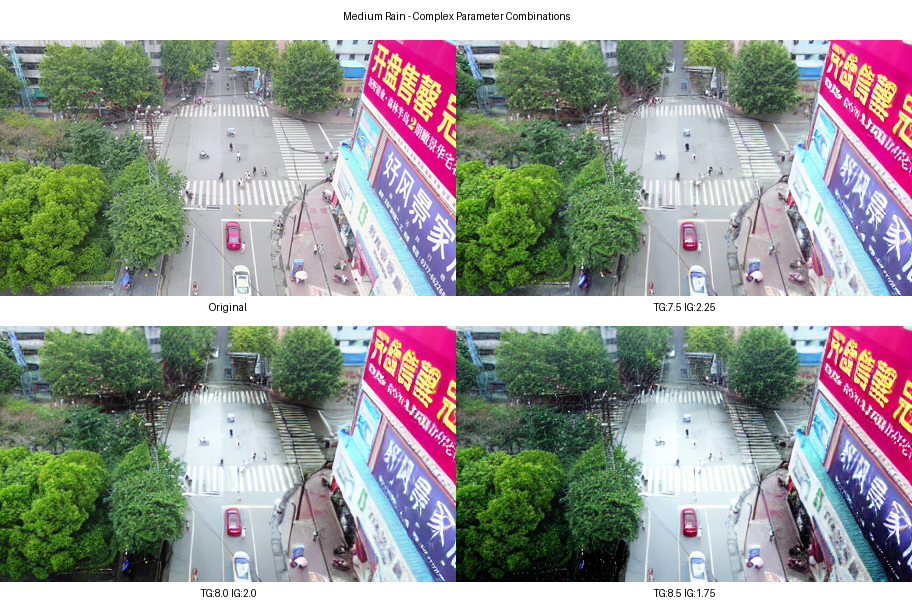

In [8]:
# More combinations (text_guidance, image_guidance)
complex_combinations = [
    (7.5, 2.25),  # Low text, low image
    (8.0, 2.0),  # Medium text, medium image
    (8.5, 1.75),  # High text, low image
]

print("\n4. Running complex combinations experiment...")
complex_images = [input_image]
complex_labels = ["Original"]

for text_guide, image_guide in complex_combinations:
    generator = torch.Generator(device="cuda").manual_seed(SEED)
    images = pipe(
        prompt,
        image=input_image,
        num_inference_steps=50,
        guidance_scale=text_guide,
        image_guidance_scale=image_guide,
        strength=default_strength,
        generator=generator,
    ).images
    complex_images.append(images[0])
    complex_labels.append(f"TG:{text_guide} IG:{image_guide}")

complex_grid = create_labeled_grid(
    complex_images,
    complex_labels,
    2,
    2,
    f"{prompt_name.title()} Rain - Complex Parameter Combinations",
)

display(complex_grid)

## Prompt Comparison

Running default parameters prompt comparison experiment...
Processing light rain with default parameters...


  8%|▊         | 4/50 [00:00<00:01, 29.94it/s]

100%|██████████| 50/50 [00:01<00:00, 26.66it/s]


Processing medium rain with default parameters...


100%|██████████| 50/50 [00:01<00:00, 26.52it/s]


Processing heavy rain with default parameters...


100%|██████████| 50/50 [00:01<00:00, 26.46it/s]


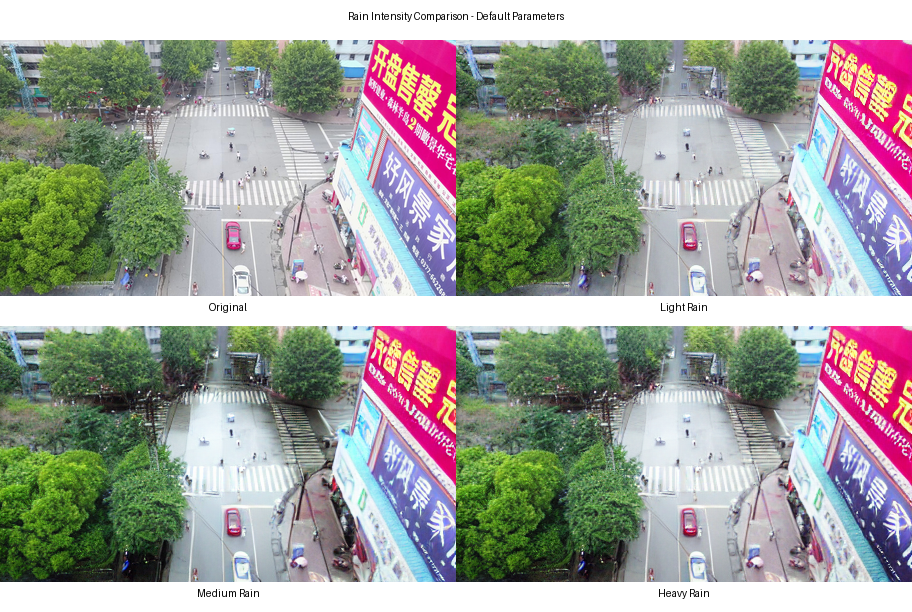

In [ ]:
# Experiment: Default parameters prompt comparison

print("Running default parameters prompt comparison experiment...")
default_prompt_images = [input_image]
default_prompt_labels = ["Original"]

# Default parameters
default_seed = 1

for prompt, prompt_name in zip(prompts, prompt_names, strict=False):
    print(f"Processing {prompt_name} rain with default parameters...")

    generator = torch.Generator(device="cuda").manual_seed(default_seed)
    images = pipe(
        prompt,
        image=input_image,
        num_inference_steps=50,
        guidance_scale=default_text_guidance,
        image_guidance_scale=default_image_guidance,
        strength=default_strength,
        generator=generator,
    ).images
    default_prompt_images.append(images[0])
    default_prompt_labels.append(f"{prompt_name.title()} Rain")

default_prompt_grid = create_labeled_grid(
    default_prompt_images,
    default_prompt_labels,
    2,
    2,
    "Rain Intensity Comparison - Default Parameters",
)

display(default_prompt_grid)